In [ ]:
!git clone https://github.com/KhushJShah/RoboChef.git

Cloning into 'RoboChef'...
remote: Enumerating objects: 1388, done.
remote: Total 1388 (delta 0), reused 0 (delta 0), pack-reused 1388
Receiving objects: 100% (1388/1388), 149.28 MiB | 17.75 MiB/s, done.
Resolving deltas: 100% (5/5), done.
Updating files: 100% (1372/1372), done.


In [ ]:
import os
os.chdir('/content/RoboChef')

In [ ]:
%ls

 dataset/         'masala box.jpg'               template-matching-orb.py    try.py
 masala_box1.jpg   smallervggnet.py              template-matching-sift.py   turmeric1.jpg
 masala_box2.jpg  'spciebox-edge detection.py'   train.py                    turmeric.jpg


In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

# Define paths
train_dir = 'dataset/'

# Image data generator for preprocessing
train_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

validation_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)

# Define the CNN model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(train_generator.num_classes, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    epochs=10
)

# Save the model
model.save('spice_detector_model.h5')


Found 1090 images belonging to 2 classes.
Found 271 images belonging to 2 classes.
Epoch 1/10
34/34 [==============================] - 41s 1s/step - loss: 0.7905 - accuracy: 0.6342 - val_loss: 0.3731 - val_accuracy: 0.9297
Epoch 2/10
34/34 [==============================] - 39s 1s/step - loss: 0.1695 - accuracy: 0.9631 - val_loss: 0.0662 - val_accuracy: 0.9805
Epoch 3/10
34/34 [==============================] - 37s 1s/step - loss: 0.0102 - accuracy: 0.9991 - val_loss: 0.0013 - val_accuracy: 1.0000
Epoch 4/10
34/34 [==============================] - 39s 1s/step - loss: 0.0114 - accuracy: 0.9962 - val_loss: 2.8797e-04 - val_accuracy: 1.0000
Epoch 5/10
34/34 [==============================] - 39s 1s/step - loss: 0.0278 - accuracy: 0.9934 - val_loss: 0.0037 - val_accuracy: 1.0000
Epoch 6/10
34/34 [==============================] - 47s 1s/step - loss: 0.0055 - accuracy: 0.9991 - val_loss: 4.3147e-04 - val_accuracy: 1.0000
Epoch 7/10
34/34 [==============================] - 41s 1s/step - los

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import numpy as np

# Load the model
model = load_model('spice_detector_model.h5')

# Load and preprocess the image
test_image_path = 'masala box.jpg'
img = image.load_img(test_image_path, target_size=(128, 128))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array /= 255.0

# Make predictions
predictions = model.predict(img_array)
predicted_class = np.argmax(predictions[0])
class_labels = train_generator.class_indices
class_labels = {v: k for k, v in class_labels.items()}  # Invert the dictionary

print(f"Predicted spice: {class_labels[predicted_class]}")


1/1 [==============================] - 0s 89ms/step
Predicted spice: Cloves


In [ ]:
model = load_model('spice_detector_model.h5')

# Class labels (make sure these match the classes in your dataset)
class_labels = {0: 'Cinnamon', 1: 'Cloves'}

In [ ]:
import cv2
import matplotlib.pyplot as plt
def preprocess_image(image_path):
    # Load image
    image = cv2.imread(image_path)
    # Convert image to RGB
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image

1/1 [==============================] - 0s 40ms/step


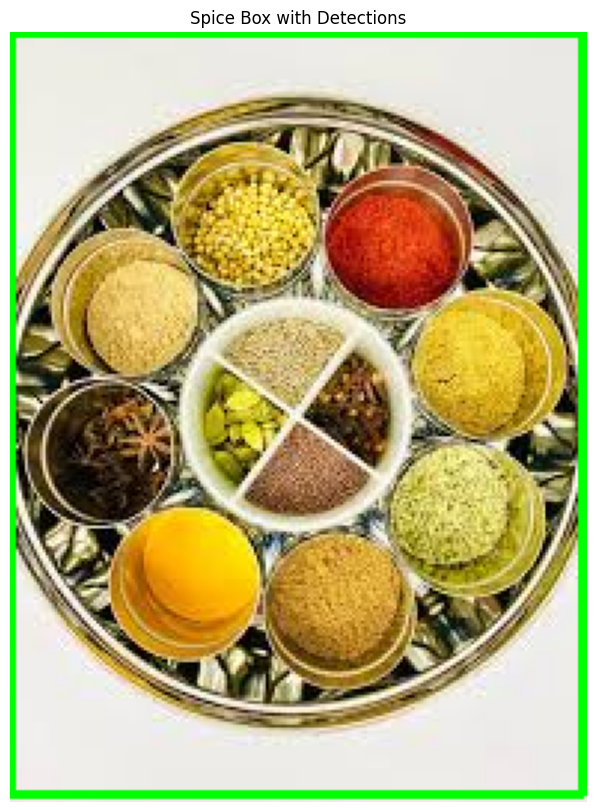

In [ ]:
from sklearn.cluster import DBSCAN
def sliding_window(image, model, window_size=(128, 128), step_size=32, confidence_threshold=0.9):
    detected_spices = []
    for y in range(0, image.shape[0] - window_size[1], step_size):
        for x in range(0, image.shape[1] - window_size[0], step_size):
            window = image[y:y + window_size[1], x:x + window_size[0]]
            if window.shape[0] != window_size[1] or window.shape[1] != window_size[0]:
                continue
            # Preprocess window
            window_array = cv2.resize(window, window_size) / 255.0
            window_array = np.expand_dims(window_array, axis=0)
            # Classify window
            predictions = model.predict(window_array)
            predicted_class = np.argmax(predictions[0])
            confidence = predictions[0][predicted_class]
            if confidence > confidence_threshold:  # Adjust confidence threshold as needed
                detected_spices.append((class_labels[predicted_class], confidence, x, y, window_size[0], window_size[1]))
    return detected_spices

def cluster_detections(detections, eps=50, min_samples=1):
    if len(detections) == 0:
        return []

    # Extract the coordinates and dimensions for clustering
    coords = np.array([[x, y, x + w, y + h] for _, _, x, y, w, h in detections])

    # Use DBSCAN clustering
    clustering = DBSCAN(eps=eps, min_samples=min_samples).fit(coords)

    # Group detections by cluster labels
    clustered_detections = []
    for cluster in np.unique(clustering.labels_):
        if cluster == -1:
            continue  # Ignore noise
        cluster_indices = np.where(clustering.labels_ == cluster)[0]
        cluster_coords = coords[cluster_indices]

        # Find the bounding box of the cluster
        x_min, y_min = np.min(cluster_coords[:, :2], axis=0)
        x_max, y_max = np.max(cluster_coords[:, 2:], axis=0)

        # Take the most common label within the cluster
        labels = [detections[i][0] for i in cluster_indices]
        common_label = max(set(labels), key=labels.count)

        clustered_detections.append((common_label, x_min, y_min, x_max - x_min, y_max - y_min))

    return clustered_detections

def draw_detections(image, detections):
    for label, x, y, w, h in detections:
        cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)
        cv2.putText(image, f'{label}', (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)
    return image
# Load and preprocess the spice box image
spice_box_image_path = 'masala box.jpg'
spice_box_image = preprocess_image(spice_box_image_path)

# Perform sliding window detection
detections = sliding_window(spice_box_image, model, confidence_threshold=0.95)  # Increase confidence threshold

# Cluster detections
clustered_detections = cluster_detections(detections)

# Draw detections on the image
annotated_image = draw_detections(spice_box_image, clustered_detections)

# Display the final image with detections
plt.figure(figsize=(10, 10))
plt.imshow(annotated_image)
plt.title('Spice Box with Detections')
plt.axis('off')
plt.show()


In [ ]:
%cd /content/RoboChef

/content/RoboChef


In [ ]:
import shutil

# Replace 'your_notebook.ipynb' with the name of your notebook
shutil.move("/content/drive/MyDrive/Colab Notebooks/Robochef.ipynb", "/content/RoboChef/Robochef.ipynb")

FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/Colab Notebooks/Robochef.ipynb'

In [ ]:
!git add Robochef.ipynb

In [ ]:
!apt-get install git

# Configure your Git username and email
!git config --global user.email "khushjayant.shah@gwmail.gwu.edu"
!git config --global user.name "KhushJShah"

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
git is already the newest version (1:2.34.1-1ubuntu1.11).
0 upgraded, 0 newly installed, 0 to remove and 45 not upgraded.


In [ ]:
!git commit -m "Add notebook"

On branch main
Your branch is ahead of 'origin/main' by 1 commit.
  (use "git push" to publish your local commits)

Untracked files:
  (use "git add <file>..." to include in what will be committed)
	spice_detector_model.h5

nothing added to commit but untracked files present (use "git add" to track)


In [ ]:
!git push origin main

fatal: could not read Username for 'https://github.com': No such device or address


/root


In [ ]:
%ls